In [8]:
%matplotlib inline


In [2]:
import pandas as pd
import matplotlib.pyplot as pyPlot

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn import metrics
import pandas.io.sql as psql
import psycopg2 as pg


/usr/local/Cellar/python/3.6.4_4/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


/Users/ca/PycharmProjects/JupyterNoteBookExample/venv/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/Users/ca/PycharmProjects/JupyterNoteBookExample/venv/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [11]:
with pg.connect(database='chi-navi-mesh',
                host='localhost',
                user='postgres',
                port=5432) as conn:
    all_season_sql = "with delay_info as( " \
                     "with route_bus_stop_list as( " \
                     "select " \
                     "t.task_id,r.route_id,b.bus_stop_id,rbs.ordinal " \
                     "from " \
                     "bus_stop b,route r,route_bus_stop rbs,task t " \
                     "where " \
                     "b.bus_stop_id = rbs.bus_stop_id " \
                     "and r.route_id = rbs.route_id " \
                     "and t.route_id = r.route_id " \
                     "order by r.route_id,rbs.ordinal " \
                     "), " \
                     "delay_list as( " \
                     "with stddev as( " \
                     "select " \
                     "stddev_samp(extract(epoch from (collide_at - departure_time))) as stddev " \
                     "from " \
                     "task_delay " \
                     "where " \
                     "(collide_at - departure_time) > '00:00:00' " \
                     "), " \
                     "delay_avg as( " \
                     "select " \
                     "avg((extract(epoch from (collide_at - departure_time)))) as delay_avg " \
                     "from " \
                     "task_delay " \
                     "where " \
                     "(collide_at - departure_time) > '00:00:00' " \
                     ") " \
                     "select " \
                     "td.task_id,td.departure_time,td.bus_stop_id,td.submit_in,td.collide_at " \
                     ",extract(epoch from (td.collide_at - td2.departure_time)) as delay " \
                     "from " \
                     "task_delay td,delay_avg da,stddev std,task_detail td2 " \
                     "where " \
                     "(extract(epoch from (td.collide_at - td2.departure_time)) between " \
                     "da.delay_avg - std.stddev * 3 and da.delay_avg + std.stddev * 3) " \
                     "and extract(epoch from (td.collide_at - td2.departure_time)) > 0 " \
                     "and td.task_id = td2.task_id " \
                     "and td.bus_stop_id = td2.bus_stop_id " \
                     "and td.departure_time = td2.departure_time " \
                     ") " \
                     "select " \
                     "distinct r.route_id,r.bus_stop_id,r.ordinal,d.collide_at, " \
                     "d.task_id,d.delay,d.submit_in,d.departure_time,date_part('HOUR' , d.departure_time) as time " \
                     "from " \
                     "delay_list d, route_bus_stop_list r " \
                     "where " \
                     "d.bus_stop_id = r.bus_stop_id " \
                     "and r.task_id = d.task_id " \
                     "), " \
                     "access_info as( " \
                     "select " \
                     "count(distinct session_id) as access_num,browsing_at::date as date," \
                     "date_part('HOUR' , browsing_at) as time, " \
                     "case when " \
                     "extract(dow from browsing_at::date) = 0 or extract(dow from browsing_at::date) = 6 then 0 " \
                     "else 1 " \
                     "end as youbi " \
                     "from " \
                     "user_browsing_log ubl " \
                     "group by date,time " \
                     ") " \
                     "select " \
                     "delay, " \
                     "ai.time, " \
                     "ai.access_num,ai.youbi, " \
                     "case " \
                     "when submit_in = '2017-07-23' then 1/* 航空祭 */ " \
                     "when (submit_in between '2018-01-26' and '2018-02-18') or " \
                     "(submit_in between '2017-01-27' and '2017-02-19') " \
                     "then 2/* ひょうとう祭り */ " \
                     "when submit_in between '2017-07-06' and '2017-07-09' then 3/* セガサミーカップ */ " \
                     "else 0 " \
                     "end as event, " \
                     "case " \
                     "when " \
                     "di.route_id in (13,14,23,24,55,56,58,59,60,61,62,63,64,67,68,69,70,71,74" \
                     ",78,79,80,81,82,91,92,93,94,95,96,97,98,99,106,107,108,109,11) then 1 " \
                     "else 0 " \
                     "end as destination " \
                     "from " \
                     "delay_info di,access_info ai " \
                     "where " \
                     "di.time = ai.time " \
                     "and di.submit_in = ai.date"


In [12]:
csv_input = pd.read_csv(filepath_or_buffer="./winter_randomForest.csv",
                        encoding="utf_8", sep=",")

sql_result = psql.read_sql(all_season_sql, conn)
# 目的変数

features_df = pd.DataFrame()

features_df['delay'] = sql_result['delay']

# 説明変数
features_df['access_num'] = sql_result['access_num']
features_df['time'] = pd.Categorical(sql_result['time'])
features_df['youbi'] = pd.Categorical(sql_result['youbi'])
features_df['event'] = pd.Categorical(sql_result['event'])
features_df['destination'] = pd.Categorical(sql_result['destination'])

# features_df['snow_fall'] = csv_input['snow_fall'].fillna(method='ffill')

X = features_df.loc[:, 'access_num':]
Y = features_df['delay']

# 学習データとテストデータの分離
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0)

# ランダムフォレストの作成
forest = RandomForestClassifier(min_samples_leaf=3, random_state=0)
forest.fit(X_train, Y_train)

# 評価
print('Train score: {}'.format(forest.score(X_train, Y_train)))
print('Test score: {}'.format(forest.score(X_test, Y_test)))
print('Confusion matrix:\n{}'.format(confusion_matrix(Y_test, forest.predict(X_test))))
print('f1 score: {:.3f}'.format(f1_score(Y_test, forest.predict(X_test))))

# ROC曲線
fpr, tpr, _ = metrics.roc_curve(Y_test, forest.predict_proba(X_test)[:, 1])

auc = metrics.auc(fpr, tpr)
print('AUC Score: {}'.format(auc))

[0.30221841 0.46257913 0.14262656 0.04616647 0.04640942]


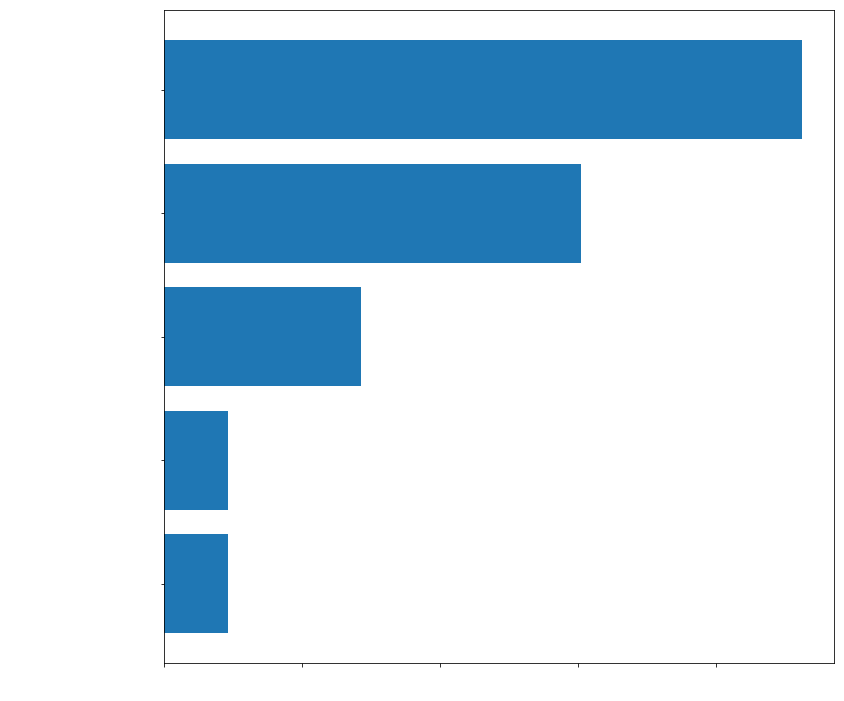

In [6]:
import matplotlib.font_manager as fm
from matplotlib.font_manager import FontProperties

font_path = './ipaexg.ttf'
font_prop = FontProperties(fname=font_path)

label = ['時間帯', 'セッション数', '曜日', 'イベント', '目的地']
# label = ['時間帯', 'セッション数', '降雪量']
print(forest.feature_importances_)
values, names = zip(*sorted(zip(forest.feature_importances_, label)))
pyPlot.figure(figsize=(12, 12))
pyPlot.barh(range(len(names)), values, align='center')
pyPlot.yticks(range(len(names)), names, fontproperties=font_prop)
pyPlot.tick_params(labelsize=25, labelcolor='white')
pyPlot.show()


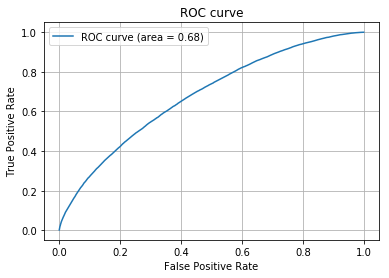

In [7]:
pyPlot.plot(fpr, tpr, label='ROC curve (area = %.2f)' % auc)
pyPlot.legend()
pyPlot.title('ROC curve')
pyPlot.xlabel('False Positive Rate')
pyPlot.ylabel('True Positive Rate')
pyPlot.grid(True)
